#### Delta Hedging

In [ ]:
# fazer as trajetórias do ativo ao longo do tempo
## gerar um movimento browniano geométrico para isso 
## ao longo de 1 até T

# calcular o PnL ao longo do tempo

# calcular o valor da call ao longo do tempo
## acredito que deve ter que calcular V(t_i, T)

# calcular o delta hedging ao longo do tempo

# juntar essas informações em um gráfico

# fazer isso para os cenários (ITM, OTM e ATM)

# ref: pag 76 cornelis

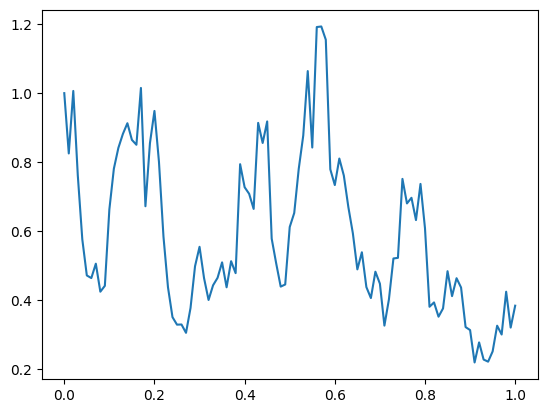

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 2
mu = 0
r = 0.1
S_0 = 1
T = 1
K = 0.95
n=100

def gbm(S0, r, sigma, T, M, I):
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

x = np.linspace(0,T,n+1)
y = [x for x in gbm(S0=S_0, r=mu, sigma=sigma, T=T, M=n, I=1)]

fig, ax = plt.subplots()

ax.plot(x,y)

plt.show()

In [ ]:
# fazer 1000 simulações de delta hedging calculando o PnL com rebalanceamto em 10 vezes

# fazer 1000 simulações de delta hedging calculando o PnL com rebalanceamto em 2000 vezes

#### funcionamento do GPR

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
S0 = 100  # Preço inicial
mu = r = 0.1  # Taxa de retorno esperada
sigma = 0.2  # Volatilidade
T = 2  # Horizonte de tempo (anos)
N = 3  # Número de passos (aprox. número de dias úteis em um ano)

def gbm(T, N, mu, sigma):
    
    dt = T / N  # Incremento de tempo
    
    # Inicialização dos vetores de tempo e preço
    t = np.linspace(0, T, N)
    S = np.ones(N)
    S[0] = S0

    # Simulação do GBM
    for i in range(0, N):
        Z = np.random.normal()
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return np.array(S)

In [2]:
tamanho_amostra = 2*10**4
numero_ativos = 1
numero_tempo = 10

X = np.array([gbm(2, numero_tempo, mu, sigma) for i in range(tamanho_amostra*numero_ativos)])
# X = X.reshape(numero_ativos*tamanho_amostra, numero_tempo)
X.shape


(20000, 10)

In [15]:
import numpy as np

def f(X, K):
    X_max = max(X)

    call = X_max - K
    return call if call > 0 else 0


n_ativos = 5
n_passos = 10
X = np.random.normal(size=(n_ativos, n_passos))
S = np.array([gbm(2, n_passos, mu, sigma) for i in range(n_ativos)])

max_call = np.array([f(S[:,i], 1) for i in range(S.shape[1])])


X_train = S
y_train = max_call

X_train.shape

(5, 10)

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# --------------------------------------
# Passo 1: Geração de dados de exemplo
# --------------------------------------
np.random.seed(42)
n_samples = 20
d = 6


X_train = S
y_train = max_call

# Exemplo de função alvo y_j = (|I_j|^{1/2} * g_j) / sqrt(w_j)


# --------------------------------------
# Passo 2: Definição do kernel e GPR
# --------------------------------------
# Limites dos hiperparâmetros
alpha_bounds = (2.8e-5, 83.0)     # bound para ConstantKernel
beta_bounds  = (1e-9, 0.15)       # bound para RBF length_scale
lambda_bounds = (1e-12, 1e-3)     # bound para WhiteKernel noise_level

# Kernel = Constant * RBF + WhiteKernel
kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=alpha_bounds) 
    * RBF(length_scale=1.0, length_scale_bounds=beta_bounds)
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=lambda_bounds)
)

# Instância do regressor gaussiano
gpr = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)

# Treinamento do modelo GPR
gpr.fit(X_train, y_train)

# Exibir o kernel ajustado e valor da log-marginal likelihood
print("Kernel ajustado:", gpr.kernel_)
print("Log-marginal likelihood:", gpr.log_marginal_likelihood(gpr.kernel_.theta))


# --------------------------------------
# Passo 3: Teste do modelo e predições
# --------------------------------------
n_test = 200
numero_ativos = 1
numero_tempo = 10

n_ativos = 5
n_passos = 10
X = np.random.normal(size=(n_ativos, n_passos))
S = np.array([gbm(2, n_passos, mu, sigma) for i in range(n_ativos)])

max_call = np.array([f(S[:,i], 1) for i in range(S.shape[1])])

X_test = S

# Predição via GPR: retorna média e desvio padrão
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Exibir amostras de predição
for i in range(4):
    print(f"X_test[{i}] = {X_test[i]}, y_pred = {y_pred[i]:}, y_std = {y_std[i]:}")


In [19]:
from sklearn.gaussian_process.kernels import Kernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

class GaussianExponentiatedKernel(Kernel):
    """k(x,y) = exp(-alpha||x-y||^2 + beta·x^T y), com clipping seguro."""
    def __init__(self, alpha=1.0, beta=0.0,
                 alpha_bounds=(1e-5, 1e5), beta_bounds=(1e-5, 1e5)):
        self.alpha = alpha
        self.beta = beta
        self.alpha_bounds = alpha_bounds
        self.beta_bounds = beta_bounds
        # máximo argumento para np.exp em float64:
        self._max_exp = np.log(np.finfo(float).max)

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        # distâncias quadráticas
        sqdists = np.sum((X[:, None, :] - Y[None, :, :])**2, axis=2)
        # produto interno
        dotprod = X.dot(Y.T)
        # montagem do expoente
        exponent = -self.alpha * sqdists + self.beta * dotprod
        # clipping para evitar overflow
        exponent = np.clip(exponent, -self._max_exp, self._max_exp)
        gram = np.exp(exponent)

        if eval_gradient:
            # gradientes parciais em relação a [alpha, beta]
            grad_alpha = -sqdists * gram
            grad_beta  =  dotprod * gram
            # empilha em (n_x, n_y, 2)
            return gram, np.stack((grad_alpha, grad_beta), axis=2)

        return gram

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return False

    @property
    def theta(self):
        return np.log([self.alpha, self.beta])

    @theta.setter
    def theta(self, theta):
        self.alpha, self.beta = np.exp(theta)

    @property
    def bounds(self):
        return np.log([self.alpha_bounds, self.beta_bounds])
    """Gaussian-Exponentiated kernel: k(x,y) = exp(-alpha||x-y||^2 + beta x^T y)."""
    def __init__(self, alpha=1.0, beta=0.0,
                 alpha_bounds=(1e-5, 1e5), beta_bounds=(1e-5, 1e5)):
        self.alpha = alpha
        self.beta = beta
        self.alpha_bounds = alpha_bounds
        self.beta_bounds = beta_bounds

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        sqdists = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
        gram = np.exp(-self.alpha * sqdists + self.beta * X.dot(Y.T))
        if eval_gradient:
            # Gradient wrt [alpha, beta]
            grad_alpha = -sqdists * gram
            grad_beta = (X.dot(Y.T)) * gram
            # Stack gradients: shape (n_samples_X, n_samples_Y, n_params)
            return gram, np.stack((grad_alpha, grad_beta), axis=2)
        return gram

    def diag(self, X):
        return np.ones(X.shape[0])

    def is_stationary(self):
        return False

    @property
    def theta(self):
        return np.log([self.alpha, self.beta])

    @theta.setter
    def theta(self, theta):
        self.alpha, self.beta = np.exp(theta)

    @property
    def bounds(self):
        return np.log([self.alpha_bounds, self.beta_bounds])

1º Passo) Gerar X

In [70]:
import numpy as np

n_ativos = 5
tempo_final = 1
incrementos = [0, 1/12, 11/12, 1]
n_tempos = len(incrementos)

X = np.random.normal(size=(n_ativos, n_tempos))
X.shape

(5, 4)

2º Passo) Define a GBM

In [71]:
def gbm(X, tempo_final, n_tempos, mu, sigma, incrementos = []):
    dt = tempo_final / n_tempos  # Incremento de tempo
    
    # Inicialização dos vetores de tempo e preço
    S = np.ones(n_tempos)
    S[0] = 1

    if len(incrementos) == 0:
        # Simulação do GBM
        for i in range(0, n_tempos):
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * X[i])

        return np.array(S)
    else:
        for i in range(0, n_tempos):
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * incrementos[i] + sigma * np.sqrt(incrementos[i]) * X[i])

        return np.array(S)

mu = 0
sigma = 0.2

S = np.array([gbm(X_i, tempo_final, n_tempos, mu, sigma, incrementos=incrementos) for X_i in X])
S

array([[1.        , 0.97408146, 1.35018773, 1.34020938],
       [1.        , 0.91670522, 0.74603078, 0.65235907],
       [1.        , 0.98262095, 1.44983499, 1.25822627],
       [1.        , 1.01696693, 1.15877569, 1.36989304],
       [1.        , 0.93358615, 1.51461572, 1.30622698]])

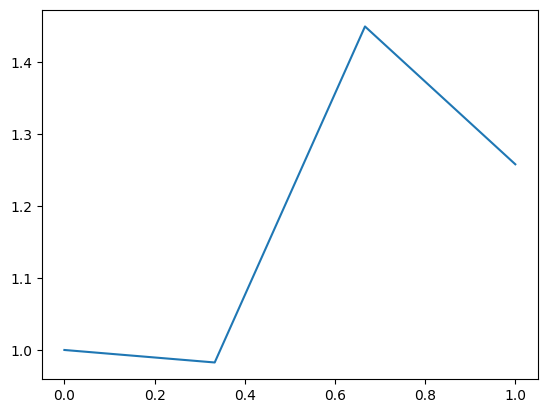

In [72]:
import matplotlib.pyplot as plt

x = np.linspace(0,tempo_final, n_tempos)
y = S[2,:]

fig, ax = plt.subplots()

ax.plot(x,y)

plt.show()

3º Passo) Calculando a $f(X)$

$$
f(X) \;=\; e^{-r \sum_{t=1}^T \Delta_t}\,\bigl(\max_i S_{i,T} - K\bigr)^{+}.
$$

In [73]:
def f(X, tempo_final, n_tempos, mu, sigma, K, r, incrementos=[]):
    S = gbm(X, tempo_final, n_tempos, mu, sigma, incrementos)

    S_T = S[-1]
    call = max([S_T - K,0])
    call_desconto = np.exp(-r*tempo_final)*call

    return call_desconto

r = 0
K = 1
n_ativos = 1
tempo_final = 1
n_tempos = 100
mu = 0
sigma = 0.2

X = np.random.normal(size=(n_tempos))
# y = f(X, tempo_final, n_tempos, mu, sigma, K, r)


4º Passo) Replicar o passo 3 'n' vezes

In [74]:
tamanho_amostra = 1000
r = 0
K = 1
n_ativos = 1
tempo_final = 2
n_tempos = len(incrementos)
mu = 0
sigma = 0.2

X_treino = np.random.normal(size=(tamanho_amostra, n_tempos))
S_final = np.array([gbm(X_treino[j,:],tempo_final, n_tempos, mu, sigma, incrementos)[-1] for j in range(X_treino.shape[0])])
y_treino = np.array([f(X_treino[j,:], tempo_final, n_tempos, mu, sigma, K, r, incrementos=incrementos) for j in range(X_treino.shape[0])])

In [75]:
S_final

array([1.03807242, 1.08003812, 0.91870826, 1.34799562, 1.57117056,
       1.43429774, 0.76368525, 0.80000325, 0.74659455, 0.75434009,
       0.74896899, 1.66498278, 1.34651559, 0.90603406, 1.74877563,
       0.6820786 , 0.82813983, 0.47153769, 1.44490243, 0.59604158,
       0.55278534, 1.40072306, 1.0511048 , 0.96906192, 1.01340314,
       1.47306296, 1.16533548, 1.11213177, 0.93946477, 0.78207159,
       0.77452954, 0.71379676, 0.85062721, 0.52394333, 1.45160983,
       0.60570007, 0.95715349, 0.86145323, 1.71245902, 0.81425224,
       1.31289597, 0.92107849, 1.26452958, 0.75337441, 1.01168652,
       0.73220959, 1.1466482 , 1.46848219, 0.9668533 , 0.75540882,
       0.97434241, 0.8493104 , 0.87726212, 0.73817808, 0.74338431,
       1.15141824, 0.6945357 , 0.96835253, 1.45676725, 1.08355554,
       1.44328849, 0.7757548 , 0.98374298, 1.31810604, 0.92431069,
       0.76839209, 0.90570335, 0.90073806, 1.49716624, 0.8838401 ,
       1.42538302, 0.98456703, 1.07292912, 0.87344889, 1.55864

In [48]:
X_treino.shape
y_treino.shape

(1000,)

In [49]:
K

1

In [50]:
gbm(X_treino[4,:], tempo_final, n_tempos, mu, sigma, incrementos)

array([1.        , 0.98909844, 1.17742681, 1.11107356])

In [51]:
y_treino[4]

np.float64(0.11107356067162999)

5º Passo) Usar o GPR para estimar $f_X(X)$

In [76]:
from sklearn.gaussian_process.kernels import Kernel, ConstantKernel, WhiteKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor


# Passo 2: Definição do kernel e GPR
# --------------------------------------
# Limites dos hiperparâmetros
alpha_bounds = (2.8e-5, 83.0)     # bound para ConstantKernel
beta_bounds  = (1e-9, 0.15)       # bound para RBF length_scale
lambda_bounds = (1e-12, 1e-3)     # bound para WhiteKernel noise_level

kernel = GaussianExponentiatedKernel(alpha=2.53*(10**(-2)), beta=0,
                                     alpha_bounds=(2.8*(10**(-5)),83),
                                     beta_bounds=(10**(-9),0.15))
gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=5,
                               normalize_y=True)

# # Instância do regressor gaussiano
# gpr = GaussianProcessRegressor(
#     kernel=kernel,
#     n_restarts_optimizer=10,
#     normalize_y=True
# )

# Treinamento do modelo GPR
gpr.fit(X_treino, y_treino)

# Exibir o kernel ajustado e valor da log-marginal likelihood
print("Kernel ajustado:", gpr.kernel_)
print("Log-marginal likelihood:", gpr.log_marginal_likelihood(gpr.kernel_.theta))

C:\Users\davia\AppData\Local\Temp\ipykernel_19416\2802743031.py:83: RuntimeWarning: divide by zero encountered in log
  return np.log([self.alpha, self.beta])
d:\mestrado\dissertacao\precificacao-opcoes\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel ajustado: GaussianExponentiatedKernel(-0.0406, -10.5)
Log-marginal likelihood: 175.7300316142339


GaussianExponentiatedKernel(0.0639, -13)

### Calculando a função g

In [59]:
def solve_g(K, f, lam):
    """
    Resolve g = (1/n K + lam * I)^{-1} f.

    Parâmetros:
    -----------
    K   : numpy.ndarray, forma (n, n)
          Matriz de Gram do kernel.
    f   : numpy.ndarray, forma (n,)
          Vetor de valores alvo.
    lam : float
          Parâmetro de regularização λ.

    Retorna:
    --------
    g   : numpy.ndarray, forma (n,)
          Coeficientes que resolvem (1/n K + lam I) g = f.
    """
    n = K.shape[0]
    A = K / n + lam * np.eye(n)
    # resolve o sistema A g = f
    g = np.linalg.solve(A, f)
    return g

In [60]:
#Calculando a matriz K
K = gpr.kernel_(X_treino)        

#usando o lambda do artigo
lam = 3.33*(10**(-8))

#calculando a f
f = y_treino

#calculando a g
g = solve_g(K, f, lam)
g.shape

(1000,)

6º Passo) Definir $M_t(X)$, m_s(y_s) e k(x, y) 


$$
M_t(y)
\;=\;
\mathbb{E}_{\mathbb{Q}}\bigl[k(X,y)\mid\mathcal{F}_t\bigr]
\;=\;
\prod_{s=0}^{t} k_s\bigl(X_s,y_s\bigr)
\;\times\;
\prod_{s=t+1}^{T} m_s\bigl(y_s\bigr),
\quad t = 0,\dots,T.
$$```



$$
m_s(y_s)
\;=\;
(1 + 2\alpha)^{-d/2}
\exp\!\Bigl(\frac{\beta^2 + 4\alpha\beta - 2\alpha}{4\alpha + 2}\,\lvert y_s\rvert^2\Bigr).
$$```


$$
k(x, y) \;=\; \exp\!\bigl(-\alpha \lVert x - y \rVert^2 + \beta\,x^\top y\bigr).
$$```


o $y$ que vai em $M_t(y)$ acredito eu que seja o X que vamos predizer.

In [61]:
def m_s(y_s, alpha, beta, d):
    """
    Fator m_s(y_s) = (1+2α)^(-d/2) * exp( ((β²+4αβ-2α)/(4α+2)) * ||y_s||² ).
    
    y_s: array shape (d,)
    alpha, beta: parâmetros
    d: dimensão do vetor y_s
    """
    norm2 = np.dot(y_s, y_s)
    coef = (1 + 2*alpha)**(-d/2)
    exponent = (beta**2 + 4*alpha*beta - 2*alpha) / (4*alpha + 2) * norm2
    return coef * np.exp(exponent)

def kernel_k(x, y, alpha, beta):
    """
    Kernel k(x,y) = exp(-alpha||x-y||^2 + beta * x^T y).
    
    x, y: arrays shape (d,)
    alpha, beta: parâmetros do kernel
    """
    diff = x - y
    return np.exp(-alpha * np.dot(diff, diff) + beta * np.dot(x, y))


def M_t(X_path, y_path, alpha, beta, t):
    """
    Cálculo de M_t(y) = Π_{s=0}^t k(X_s, y_s) * Π_{s=t+1}^T m_s(y_s).
    
    X_path, y_path: arrays shape (T+1, d)
    alpha, beta: parâmetros do kernel
    t: índice de tempo
    """
    T = X_path.shape[1] - 1
    d = 1
    # Produto dos kernels até t
    prod_k = 1.0
    for s in range(t+1):
        prod_k *= kernel_k(X_path[s], y_path[s], alpha, beta)
    # Produto dos fatores m_s para s>t
    prod_m = 1.0
    for s in range(t+1, T+1):
        prod_m *= m_s(y_path[s], alpha, beta, d)
    return prod_k * prod_m

def V_X(X, T, g, n_tempos, alpha, beta, tamanho_amostra):

    t = np.linspace(0, T, n_tempos)
    valores_t = []
    for s in range(t.shape[0]):
        v_x = 0
        
        for j in range(X.shape[0]):
            v_x = v_x + M_t(X_treino, X_treino[j,:], alpha, beta, s)[0]*g[j]

        valores_t.append(v_x/tamanho_amostra)

    return valores_t

V_X_t = V_X(X_treino, tempo_final, g, n_tempos, alpha = 2.53*(10**(-2)), beta=0, tamanho_amostra=tamanho_amostra)
V_X_t



[np.float64(10.485074504441814),
 np.float64(7.544779896673494),
 np.float64(4.556210108890704),
 np.float64(3.4696140199710066)]

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

X_treino = np.random.normal(size=(tamanho_amostra, n_tempos))
S_final_treino = np.array([gbm(X_treino[j,:],tempo_final, n_tempos, mu, sigma, incrementos)[-1] for j in range(X_treino.shape[0])])
y_treino = np.array([f(X_treino[j,:], tempo_final, n_tempos, mu, sigma, K, r, incrementos=incrementos) for j in range(X_treino.shape[0])])

alpha_bounds = (2.8e-5, 83.0)    
beta_bounds  = (1e-9, 0.15)      
lambda_bounds = (1e-12, 1e-3)   

kernel = GaussianExponentiatedKernel(alpha=2.53*(10**(-2)), beta=0,
                                     alpha_bounds=(2.8*(10**(-5)),83),
                                     beta_bounds=(10**(-9),0.15))
gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=5,
                               normalize_y=True)

gpr.fit(X_treino, y_treino)

# Generate test points
X_test = np.random.normal(size=(1000, n_tempos))
S_final_test = np.array([gbm(X_test[j,:],tempo_final, n_tempos, mu, sigma, incrementos)[-1] for j in range(X_test.shape[0])])
y_mean, y_std = gpr.predict(X_test, return_std=True)


C:\Users\davia\AppData\Local\Temp\ipykernel_19416\2802743031.py:83: RuntimeWarning: divide by zero encountered in log
  return np.log([self.alpha, self.beta])
d:\mestrado\dissertacao\precificacao-opcoes\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\mestrado\dissertacao\precificacao-opcoes\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


In [88]:
y_true

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.48112539e-01,
       6.66272513e-02, 0.00000000e+00, 4.85466120e-01, 1.68592197e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.19770617e-02, 0.00000000e+00, 0.00000000e+00,
       5.32017977e-01, 0.00000000e+00, 6.55139469e-01, 3.15176732e-04,
       0.00000000e+00, 0.00000000e+00, 1.52016120e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.05822632e-02, 0.00000000e+00,
       4.85908606e-01, 0.00000000e+00, 5.58140393e-01, 0.00000000e+00,
       8.73913679e-03, 4.28883333e-01, 0.00000000e+00, 0.00000000e+00,
       1.00100953e+00, 3.18274248e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.76506437e-02, 0.00000000e+00, 1.79349854e-01,
       0.00000000e+00, 1.34958449e-01, 0.00000000e+00, 1.39040671e-01,
       1.38464996e-01, 8.33526782e-02, 4.71738640e-01, 8.05446912e-03,
       1.72072632e-01, 1.39420484e-01, 0.00000000e+00, 5.67960006e-01,
      

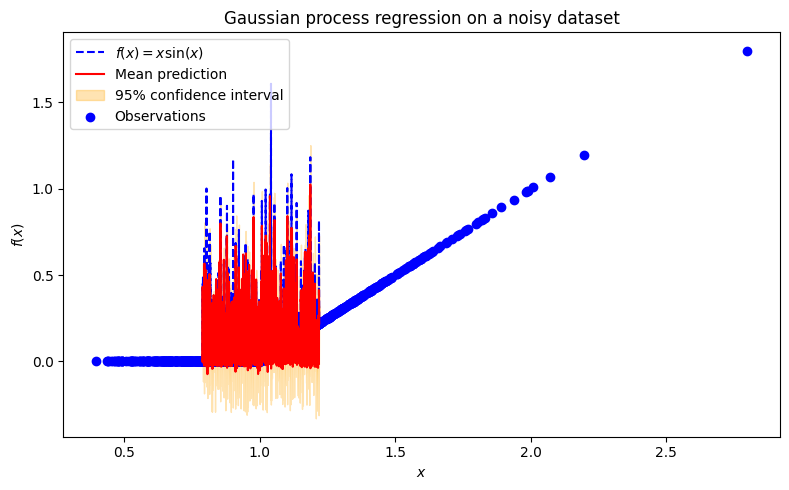

In [93]:
# True function
y_true = np.array([f(X_test[j,:], tempo_final, n_tempos, mu, sigma, K, r, incrementos=incrementos) for j in range(X_test.shape[0])])

X_teste = np.linspace(S_final_test[0], S_final_test[-1],y_true.shape[0])

X = S_final_treino
y = y_treino

# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_teste, y_true, 'b--', label=r'$f(x) = x\sin(x)$')
plt.plot(X_teste, y_mean, 'r-', label='Mean prediction')
plt.fill_between(X_teste,
                 y_mean - 1.96*y_std,
                 y_mean + 1.96*y_std,
                 color='orange', alpha=0.3, label='95% confidence interval')
plt.scatter(X, y, c='b', marker='o', label='Observations')
plt.title('Gaussian process regression on a noisy dataset')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [95]:
#Calculando os testes
n_teste = 10**5

X_teste = np.random.normal(size=(n_teste, n_tempos))
S_final_teste = np.array([gbm(X_teste[j,:], tempo_final, n_tempos, mu, sigma, incrementos)[-1] for j in range(X_teste.shape[0])])
y_teste = np.array([f(X_teste[j,:], tempo_final, n_tempos, mu, sigma, K, r, incrementos=incrementos) for j in range(X_teste.shape[0])])

V_0 = np.mean(y_teste)
V_0

np.float64(0.11303187639269789)

In [99]:
(V_X_t[0] - V_0)/V_0

np.float64(91.76210250650296)

In [210]:
def simulate_geometric_brownian(n_paths, T, d, S0, r, sigma, dt=[]):
    """
    Simula trajetórias de movimento geométrico browniano.
    
    Parâmetros:
    -----------
    n_paths : int
        Número de trajetórias a simular.
    T : int
        Número de passos de tempo (horizonte).
    d : int
        Número de ativos.
    S0 : array_like, shape (d,)
        Preço inicial de cada ativo no tempo 0.
    r : float
        Taxa livre de risco.
    sigma : float
        Volatilidade.
    dt : float
        Tamanho do passo de tempo.
        
    Retorna:
    --------
    X : ndarray, shape (n_paths, T+1, d)
        Trajetórias simuladas. X[:,0,:] = S0.
    """
    S = np.zeros((n_paths, len(dt), d))
    S[:, 0, :] = S0
    for t in range(1, len(dt)):
        Z = np.random.randn(n_paths, d)
        S[:, t, :] = S[:, t-1, :] * np.exp(
            (r - 0.5 * sigma**2) * dt[t] + sigma * np.sqrt(dt[t]) * Z
        )
    return S

n_inner = 1000
simulate_geometric_brownian(n_inner, T, S0=1, d=1, r=0, sigma=0.2, dt=[1/12, 11/12, 1])

array([[[1.        ],
        [0.97531917],
        [1.1300201 ]],

       [[1.        ],
        [0.91515233],
        [1.19154332]],

       [[1.        ],
        [1.31175885],
        [1.65848356]],

       ...,

       [[1.        ],
        [1.18278682],
        [1.15784841]],

       [[1.        ],
        [1.00652304],
        [1.28549407]],

       [[1.        ],
        [0.73915493],
        [0.75220866]]], shape=(1000, 3, 1))

In [211]:
def payoff_discounted(S, r, K, dt=1.0):
    """
    Calcula o payoff descontado e^{-r*T} * max_i S_{i,T} - K)^+.
    
    Parâmetros:
    -----------
    X : ndarray, shape (n_paths, T+1, d)
        Trajetórias simuladas.
    r : float
        Taxa livre de risco.
    K : float
        Strike da opção.
    dt : float
        Tamanho do passo de tempo.
        
    Retorna:
    --------
    payoffs : ndarray, shape (n_paths,)
        Payoff descontado de cada trajetória.
    """
    # T = X.shape[1] - 1
    # discount = np.exp(-r * T * dt) ignorar o valor de desconto por enquanto
    ST = S[:, -1, :]  # preços finais
    payoffs = np.maximum(ST.max(axis=1) - K, 0.0)
    # return discount * payoffs
    return payoffs

S1 = simulate_geometric_brownian(n_inner, T, S0=0.9, d=1, r=0, sigma=0.2, dt=[1/12, 11/12, 1])
f_X1 = payoff_discounted(S1, r=0, K=1)
np.mean(f_X1)

np.float64(0.0695826345835153)

In [215]:
def nested_monte_carlo_value_d(n_test, n_inner, T, d, r, sigma, K, dt, dt_total):

    vetor_S = simulate_geometric_brownian(n_test, T, S0=1, d=d, r=r, sigma=sigma, dt=dt_total)
    vetor_S = vetor_S[:,-len(dt),:]
    vetor_v = []

    for S_i in vetor_S:
        S = simulate_geometric_brownian(n_inner, T, S0=S_i, d=d, r=r, sigma=sigma, dt=dt)
        # print(S.shape)
        f_X = payoff_discounted(S, r=r, K=K)

        vetor_v.append(np.mean(f_X))
    
    return np.mean(vetor_v)

n_test = 10**3
n_inner = 10**2
d=1
K = 1
T = 2
dt = [11/12, 1]
dt_total = [1/12, 11/12, 1]
r = 0
sigma = 0.2

V_1 = nested_monte_carlo_value_d(n_test, n_inner, T, d, r, sigma, K, dt=dt, dt_total=dt_total)
V_1

np.float64(0.11014342751059338)

In [207]:
import numpy as np

def simulate_geometric_brownian(n_paths, T, d, S0, r, sigma, dt=1.0):
    """
    Simula trajetórias de movimento geométrico browniano.
    
    Parâmetros:
    -----------
    n_paths : int
        Número de trajetórias a simular.
    T : int
        Número de passos de tempo (horizonte).
    d : int
        Número de ativos.
    S0 : array_like, shape (d,)
        Preço inicial de cada ativo no tempo 0.
    r : float
        Taxa livre de risco.
    sigma : float
        Volatilidade.
    dt : float
        Tamanho do passo de tempo.
        
    Retorna:
    --------
    X : ndarray, shape (n_paths, T+1, d)
        Trajetórias simuladas. X[:,0,:] = S0.
    """
    X = np.zeros((n_paths, T+1, d))
    X[:, 0, :] = S0
    for t in range(1, T+1):
        Z = np.random.randn(n_paths, d)
        X[:, t, :] = X[:, t-1, :] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )
    return X

def payoff_discounted(X, r, K, dt=1.0):
    """
    Calcula o payoff descontado e^{-r*T} * max_i S_{i,T} - K)^+.
    
    Parâmetros:
    -----------
    X : ndarray, shape (n_paths, T+1, d)
        Trajetórias simuladas.
    r : float
        Taxa livre de risco.
    K : float
        Strike da opção.
    dt : float
        Tamanho do passo de tempo.
        
    Retorna:
    --------
    payoffs : ndarray, shape (n_paths,)
        Payoff descontado de cada trajetória.
    """
    T = X.shape[1] - 1
    discount = np.exp(-r * T * dt)
    ST = X[:, -1, :]  # preços finais
    payoffs = np.maximum(ST.max(axis=1) - K, 0.0)
    return discount * payoffs

def nested_monte_carlo_value(n_test, n_inner, T, d, S0, r, sigma, K, dt=1.0):
    """
    Estima V0 e V1 via Monte Carlo simples e aninhado.
    
    Parâmetros:
    -----------
    n_test  : int
        Número de trajetórias externas.
    n_inner : int
        Número de trajetórias internas (MC aninhado).
    T       : int
        Horizonte de tempo.
    d       : int
        Número de ativos.
    S0      : array_like, shape (d,)
        Preço inicial.
    r, sigma, K, dt : floats
        Parâmetros do modelo.
        
    Retorna:
    --------
    V0, V1 : floats
        Estimativas de V_0 e V_1.
    """
    # 1) Simulações externas
    X_ext = simulate_geometric_brownian(n_test, T, d, S0, r, sigma, dt)
    f_ext = payoff_discounted(X_ext, r, K, dt)
    V0 = f_ext.mean()
    
    # 2) Monte Carlo aninhado para V1
    V1_samples = np.zeros(n_test)
    for i in range(n_test):
        # preço no tempo 1 como novo "inicial" para MC interno
        S1 = X_ext[i, 1, :]
        # simula MC interno a partir de S1 até T
        X_int = simulate_geometric_brownian(n_inner, T-1, d, S1, r, sigma, dt)
        # pagaoffs internos (desconta até T)
        f_int = payoff_discounted(X_int, r, K, dt)
        V1_samples[i] = f_int.mean()
    V1 = V1_samples.mean()
    
    return V0, V1

# Exemplo de uso:

# Parâmetros
n_test, n_inner = 10000, 1000
T, d = 2, 2
S0 = np.array([0.8, 1.2])
r, sigma, K = 0, 0.2, 1
   
V0, V1 = nested_monte_carlo_value(
     n_test, n_inner, T, d, S0, r, sigma, K
    )
print(f"V0 estimate = {V0:.4f}")
print(f"V1 estimate = {V1:.4f}")


V0 estimate = 0.2619
V1 estimate = 0.2642


https://github.com/rosieiiiii/KR_return_example/blob/main/KR_return_example.ipynb

In [ ]:
https://github.com/SohamDutta2002/Finance

np.float64(0.1180179842766444)